In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
from IPython.display import clear_output

In [2]:
from engine import Value
from nn import Neuron, Layer, MLP

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [3]:
np.random.seed(1337)
random.seed(1337)


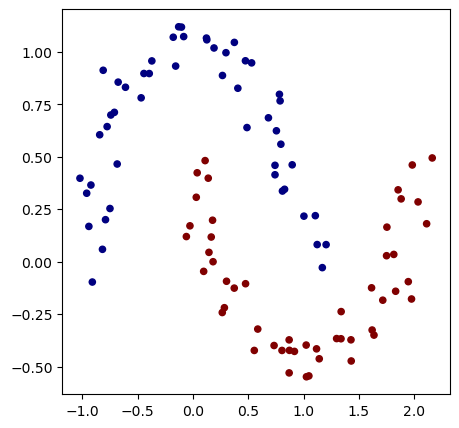

In [4]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [5]:
# initialize a model 
model = MLP(2, [10, 10, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))



MLP of [Layer of [SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2), SINNeuron(2)], Layer of [SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10), SINNeuron(10)], Layer of [SINNeuron(10)]]
number of parameters 151


In [6]:
a = model.layers[0] 
n = a.neurons[0]
n.w

[Value(data=0.40790786195267437, grad=0),
 Value(data=0.11523532725356711, grad=0)]

In [7]:
#intitalized the first stage
#grab the first layer
a = model.layers[0]
for n in a.neurons:
    for w in n.w:
        temp = random.uniform(-1 / len(n.w), 1 / len(n.w)) *30
        w.data = temp
        print(w)

print("\n")
a = model.layers[2]
for n in a.neurons:
    for w in n.w:
        print(w)

Value(data=4.096485386835081, grad=0)
Value(data=-10.67792021699275, grad=0)
Value(data=9.61049980125564, grad=0)
Value(data=7.877831104314308, grad=0)
Value(data=-7.8986514988343135, grad=0)
Value(data=9.393356749793345, grad=0)
Value(data=-12.425061808353659, grad=0)
Value(data=5.8210777497763955, grad=0)
Value(data=-4.72505135406861, grad=0)
Value(data=10.237832650190882, grad=0)
Value(data=-6.7437079194804, grad=0)
Value(data=0.814823542428269, grad=0)
Value(data=2.8258247468524313, grad=0)
Value(data=-3.3372712888238976, grad=0)
Value(data=-10.813781610769146, grad=0)
Value(data=10.765186237524869, grad=0)
Value(data=0.1283277380078618, grad=0)
Value(data=-3.636452884475184, grad=0)
Value(data=4.184773216615401, grad=0)
Value(data=-11.589482352063783, grad=0)


Value(data=0.2189105581790609, grad=0)
Value(data=-0.29908719285356694, grad=0)
Value(data=0.6862554184533325, grad=0)
Value(data=0.07144987829012639, grad=0)
Value(data=0.4350156868861492, grad=0)
Value(data=0.579392826958

In [8]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9161389369949051, grad=0) 0.68


In [9]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*(k)/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9161389369949051, accuracy 68.0%
step 1 loss 0.6522877646570515, accuracy 79.0%
step 2 loss 0.5332393790854226, accuracy 85.0%
step 3 loss 0.46276582882308265, accuracy 89.0%
step 4 loss 0.4155089865502281, accuracy 91.0%
step 5 loss 0.38074801670175806, accuracy 93.0%
step 6 loss 0.35068071993895533, accuracy 94.0%
step 7 loss 0.31858915243655606, accuracy 94.0%
step 8 loss 0.2829486597366667, accuracy 96.0%
step 9 loss 0.2567136732513125, accuracy 97.0%
step 10 loss 0.24238853035308977, accuracy 98.0%
step 11 loss 0.2334218575957251, accuracy 99.0%
step 12 loss 0.22659086459739552, accuracy 99.0%
step 13 loss 0.22107631155708418, accuracy 99.0%
step 14 loss 0.21631865464712932, accuracy 99.0%
step 15 loss 0.21217416896555572, accuracy 99.0%
step 16 loss 0.20843971856352578, accuracy 99.0%
step 17 loss 0.2050748667750742, accuracy 99.0%
step 18 loss 0.2019831805336261, accuracy 99.0%
step 19 loss 0.1991421610678249, accuracy 99.0%
step 20 loss 0.19649749981175335, accura

(-1.548639298268643, 1.951360701731357)

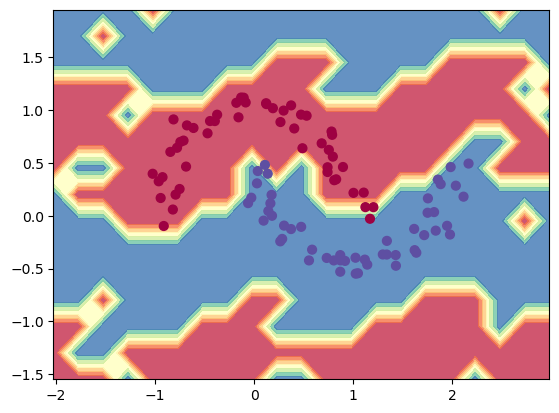

In [10]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Value(data=-18.490920919448822, grad=0)
Value(data=20.24286369247041, grad=0)
Value(data=9.32718425854047, grad=0)
Value(data=15.241019100793554, grad=0)
Value(data=-3.9750694321948954, grad=0)


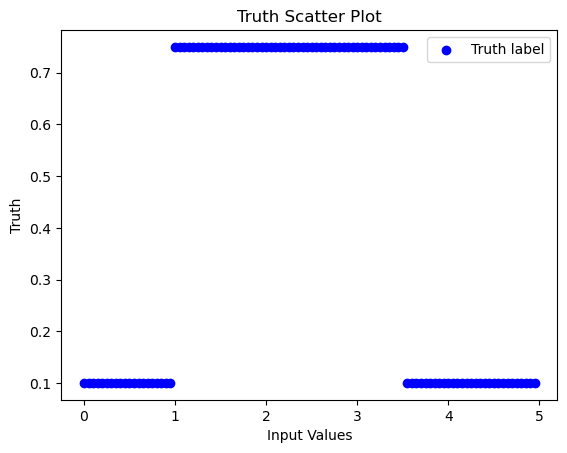

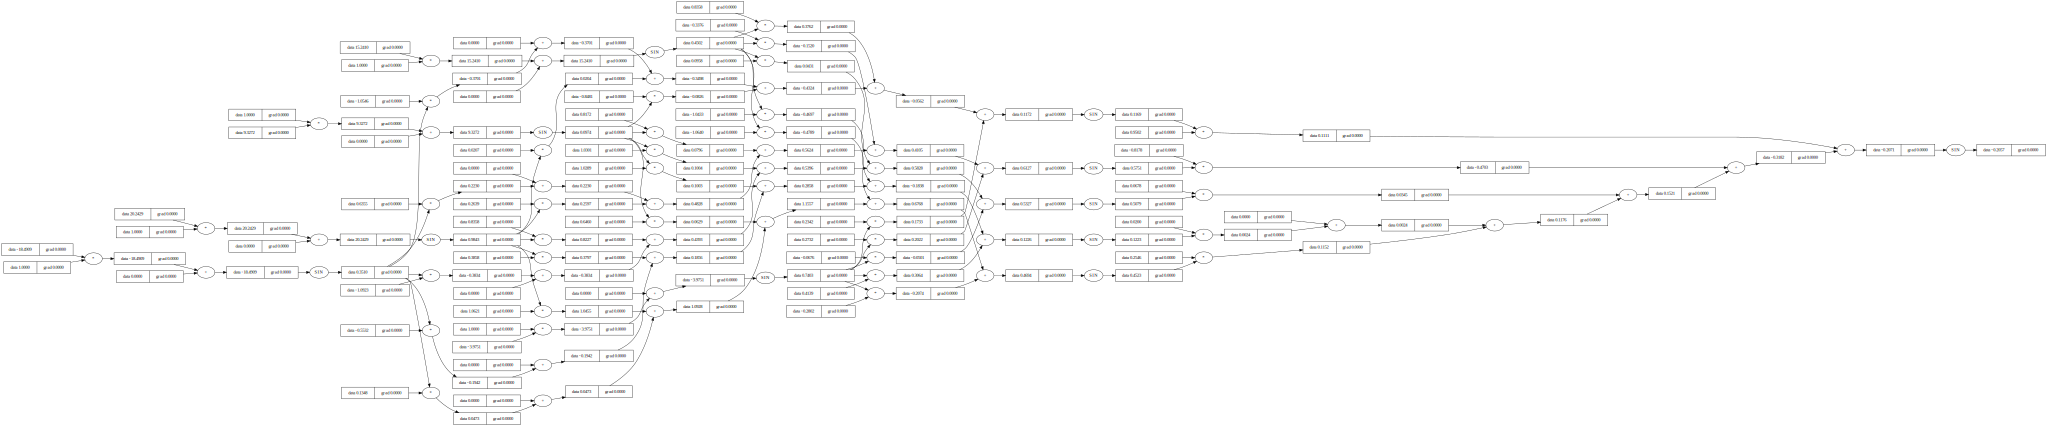

In [31]:
nn = MLP(1,[5,5,1])

#intitalized the first stage
#grab the first layer
a = nn.layers[0]
for n in a.neurons:
    for w in n.w:
        temp = random.uniform(-1 / len(n.w), 1 / len(n.w)) *30
        w.data = temp
        print(w)

        
xs = [x * 0.05 for x in range(0, 100)]
y_true = []

for x in xs:
    if x < 1 or x>3.5:
        y_true.append(0.1)
    else:
        y_true.append(0.75)
        

plt.scatter(xs, y_true, label='Truth label', marker='o', color='blue')
plt.xlabel('Input Values')
plt.ylabel('Truth')
plt.title('Truth Scatter Plot')
plt.legend()
plt.show()
draw_dot(nn([1]))

In [40]:
sgd = 50000

y_predicted = [nn([x]) for x in xs]

loss = sum((y1-y2).abs() for y1,y2 in zip(y_predicted,y_true))

#for adam optimizer:
b1 = 0.99
b2 = 0.9
e = 10**(-8)
step = 0.01
for i in range(sgd):    
    nn.zero_grad()
    loss.backward()
    for p in nn.parameters():
        # momentum optimizer
        p.Vd = b1*p.Vd+(1-b1)* p.grad
        #RMSpropagation
        p.Sd = b2*p.Sd + (1-b2)*(p.grad**2)
        
        
        
        p.data += -step * (p.Vd/((p.Sd+e)**(0.5)))
    
    xs = [random.uniform(0,5) for x in range(0, 10)]
    y_true = []
    for x in xs:
        if x < 1 or x>3.5:
            y_true.append(0)
        else:
            y_true.append(0.75)

    y_predicted = [nn([x]) for x in xs]
    #print(x)
        #print(y_true)
        #print(y_predicted)
    
    
    
    loss = sum((y1-y2).abs() for y1,y2 in zip(y_predicted,y_true))
    
    if i % 100 == 1:
        clear_output(wait=True)
        print(i)
        y_print = [n.data for n in y_predicted]
        # Plot the graph
        plt.scatter(xs, y_print, label='NN Predictions', marker='o', color='red')
        plt.scatter(xs, y_true, label='True label', marker='o', color='blue')
        plt.xlabel('Input Values')
        plt.ylabel('Predictions')
        plt.title('Neural Network Predictions')
        plt.legend()
        plt.show()
        print(loss.data)
print(loss.data)

2201


KeyboardInterrupt: 

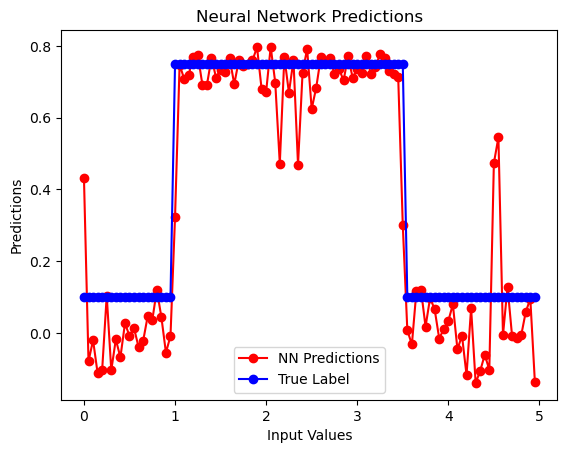

In [41]:
xs = [x * 0.05 for x in range(0, 100)]
y_true = []

for x in xs:
    if x < 1 or x>3.5:
        y_true.append(0.1)
    else:
        y_true.append(0.75)

y_print = [nn([x]).data for x in xs]
# Plot the graph
plt.plot(xs, y_print, label='NN Predictions', marker='o', color='red')
plt.plot(xs, y_true, label='True Label', marker='o', color='blue')
plt.xlabel('Input Values')
plt.ylabel('Predictions')
plt.title('Neural Network Predictions')
plt.legend()
plt.show()

In [15]:
draw_dot(nn([0.5]))

NameError: name 'draw_dot' is not defined

0


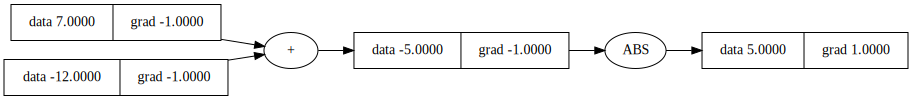

In [5]:
from engine import Value
a = Value(-12)
a
b = Value(7)
b
c = a + b
d = c.abs()

d.backward()
d
draw_dot(d)

In [15]:
xs = [random.unifom(0,5) for x in range(0, 5)]
y_true = []

for x in xs:
    if x < 1 or x>3.5:
        y_true.append(0)
    else:
        y_true.append(0.75)

In [26]:
xs = [random.uniform(0,5) for x in range(0, 5)]
y_true = []
for x in xs:
    if x < 1 or x>3.5:
        y_true.append(0)
    else:
        y_true.append(0.75)


[0, 0.75, 0, 0, 0.75]

In [27]:
xs

[4.64403812888987,
 2.42184010359206,
 0.756354433724245,
 0.5427067638803557,
 1.0239722533165336]